# 주제 : 오토인코더_사진확대
--------------

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34


## part1. 자료 load 및 확인
- 자료준비:  7월25일 강의자료의  'pfcn.npz' 자료를 준비

#### [미션1-1]
- pfcn.npz 파일을  로드하고 train의 이미지,test의 이미지 자료 할당
- train과 test의 이미지를 한개의  y값으로 제작


In [2]:
# 데이터 불러오고 train과 test에 값 할당
data = np.load('./data/pfcn.npz')
list(data)

['train_images', 'test_images', 'train_mattes', 'test_mattes']

In [3]:
train_images = data['train_images']
train_mattes = data['train_mattes']
test_images = data['test_images']
test_mattes = data['test_mattes']

In [4]:
# train_image와 test_image 의 shpae 확인
train_images.shape, test_images.shape

((1700, 100, 75, 3), (300, 100, 75, 3))

In [5]:
# train_image와 test_image 값 한개의 y로 제작
y_data = np.append(train_images, test_images, axis=0)

In [6]:
# y값 shape 확인 (2000,100,75,3)
y_data.shape

(2000, 100, 75, 3)

### [미션 1-2] y값 이미지 확인
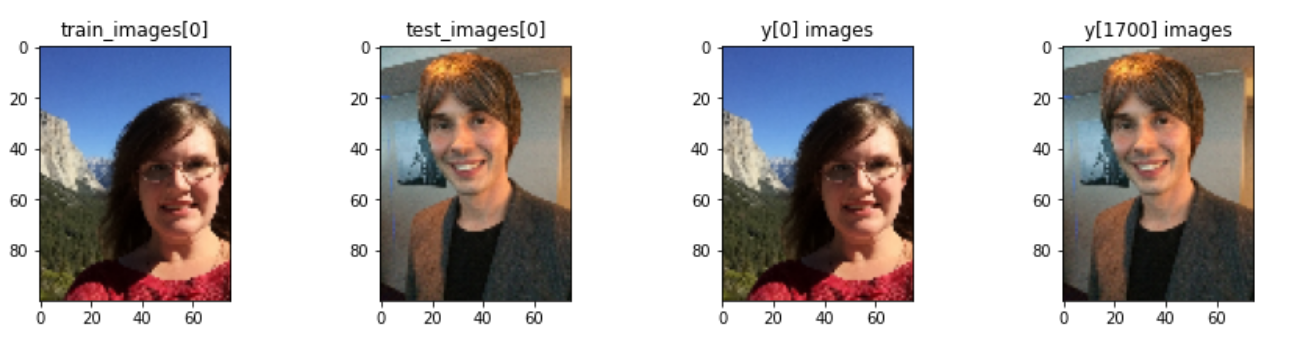

Text(0.5, 1.0, 'y_data[1700]')

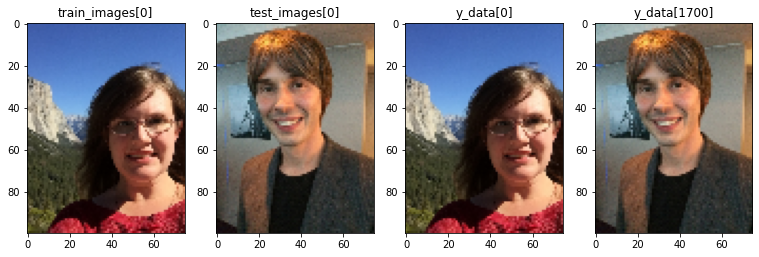

In [7]:
##  y[0] 과 y[1700] 이미지 출력

plt.figure(figsize=(13, 5))

plt.subplot(1, 4, 1)
plt.imshow(train_images[0])
plt.title('train_images[0]')

plt.subplot(1, 4, 2)
plt.imshow(test_images[0])
plt.title('test_images[0]')

plt.subplot(1, 4, 3)
plt.imshow(y_data[0])
plt.title('y_data[0]')

plt.subplot(1, 4, 4)
plt.imshow(y_data[1700])
plt.title('y_data[1700]')

## part2. x값 제작
- 100,75,3 의 y값을 50,37,3 의 x값으로 제작 하여 shape 확인 
    -x 출력 결과 (2000,50, 37, 3, 3)

In [8]:
from skimage.transform import resize
x_data = resize(y_data, (2000, 50, 37, 3))

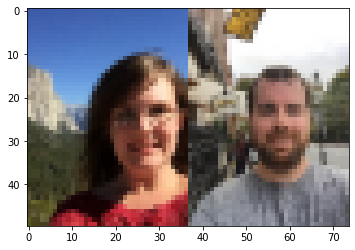

In [9]:
# 2개의 이미지 출력
plt.imshow(np.hstack([x_data[0], x_data[1]]))

## Part2. train, test 값 제작
- 20%를 test 값으로 제작
- x_train, y_train, x_test, y_test 값 제작
((1600, 50, 37, 3), (1600, 100, 75, 3), (400, 50, 37, 3), (400, 100, 75, 3))

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1600, 50, 37, 3), (1600, 100, 75, 3), (400, 50, 37, 3), (400, 100, 75, 3))

## Part3. 모델링 - unet 모델로 제작
- x데이터(50,37,3)을 y값(100,75,3) 될수 있도록 모델 제작 

### [3-1] 모델 제작

In [11]:
# input (50, 37, 3), output (100, 75, 3)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model
from keras.layers import MaxPool2D, BatchNormalization, Dropout, Activation, concatenate

def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def unet_resoultion():
    inputs = Input((50, 37, 3))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(128, 2, 2)(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 2, 2, padding="valid", output_padding=(0,1))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 2, 2, padding="valid", output_padding=(1,0))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, padding="valid", output_padding=(0,1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    u10 = Conv2DTranspose(16, 2, 2, padding="valid", output_padding=(0,1))(c9)
    outputs = Conv2D(3, 1, activation="sigmoid")(u10)
    model = Model(inputs, outputs)
    return model

In [12]:
# unet_resolution() 모델을 할당 받고 서머리를 출력하는 코드를 작성하세요.
model = unet_resoultion()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 37, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 50, 37, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 50, 37, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 50, 37, 16)   0           ['batch_normalization[0][0]']

                                                                                                  
 conv2d_9 (Conv2D)              (None, 3, 2, 256)    590080      ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 3, 2, 256)   1024        ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_9 (Activation)      (None, 3, 2, 256)    0           ['batch_normalization_9[0][0]']  
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 6, 4, 128)   131200      ['activation_9[0][0]']           
 ose)                                                                                             
          

                                                                                                  
 batch_normalization_16 (BatchN  (None, 50, 37, 16)  64          ['conv2d_16[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_16 (Activation)     (None, 50, 37, 16)   0           ['batch_normalization_16[0][0]'] 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 50, 37, 16)   2320        ['activation_16[0][0]']          
                                                                                                  
 batch_normalization_17 (BatchN  (None, 50, 37, 16)  64          ['conv2d_17[0][0]']              
 ormalization)                                                                                    
          

In [13]:
# 만든 모델에 loss는 mae, optimizer는 adam 매트릭은 accuracy으로 설정하는 코드를 작성하세요.
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint
modelpath = "./save/u_net-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose = 1, )

In [15]:
# x,y값 (validation_data=(x_test, y_test)) 학습시키고 5 epochs을 돌리고 그 진행 사항을 hist에 저장하는 코드를 작성하세요.
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 30, callbacks=[checkpointer])

Epoch 1/30
49/50 [============================>.] - ETA: 0s - loss: 0.1546 - accuracy: 0.6344
Epoch 1: saving model to ./save\u_net-01-0.6631.hdf5
50/50 [==============================] - 5s 28ms/step - loss: 0.1533 - accuracy: 0.6345 - val_loss: 0.1896 - val_accuracy: 0.6631
Epoch 2/30
49/50 [============================>.] - ETA: 0s - loss: 0.0727 - accuracy: 0.7084
Epoch 2: saving model to ./save\u_net-02-0.7143.hdf5
50/50 [==============================] - 1s 18ms/step - loss: 0.0725 - accuracy: 0.7095 - val_loss: 0.1785 - val_accuracy: 0.7143
Epoch 3/30
49/50 [============================>.] - ETA: 0s - loss: 0.0647 - accuracy: 0.7554
Epoch 3: saving model to ./save\u_net-03-0.7278.hdf5
50/50 [==============================] - 1s 18ms/step - loss: 0.0647 - accuracy: 0.7558 - val_loss: 0.1566 - val_accuracy: 0.7278
Epoch 4/30
49/50 [============================>.] - ETA: 0s - loss: 0.0611 - accuracy: 0.7722
Epoch 4: saving model to ./save\u_net-04-0.7534.hdf5
50/50 [===============

50/50 [==============================] - 1s 19ms/step - loss: 0.0490 - accuracy: 0.8227 - val_loss: 0.0535 - val_accuracy: 0.8288


### [3-2] 모델 결과 시각화

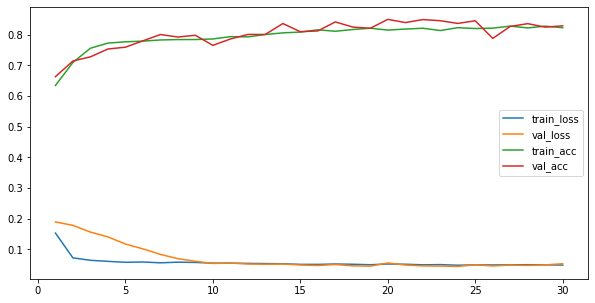

In [20]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
his_dict = hist.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] 
acc = his_dict['accuracy']
val_acc = his_dict['val_accuracy']
epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
plt.plot(epochs, loss, label = 'train_loss')
plt.plot(epochs, val_loss, label = 'val_loss')
plt.plot(epochs, acc, label = 'train_acc')
plt.plot(epochs, val_acc, label = 'val_acc')
plt.legend()

plt.show()

## part4. 모델 예측

13/13 [==============================] - 0s 31ms/step


Text(0.5, 1.0, 'unet model result')

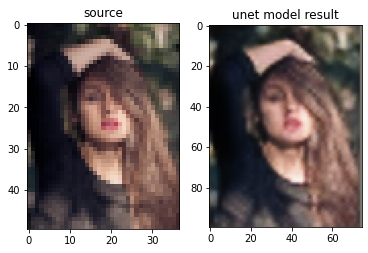

In [21]:
# 모델에 test_small_images 중 1장을 넣고 결과를 받는 코드를 작성하세요.
result = model.predict(x_test)
plt.subplot(1, 2, 1)
plt.imshow(x_test[0])
plt.title('source')
plt.subplot(1, 2, 2)
plt.imshow(result[0])
plt.title('unet model result')

1/1 [==============================] - 0s 21ms/step


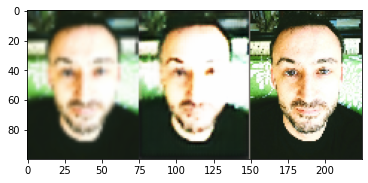

In [45]:
# np.concatenate 함수를 이용하여서 x값, y값, 모델 예측값을 출력
result = model.predict(x_train[:1])
x = resize(x_train[:1], (1, 100, 75, 3))
plt.imshow(np.concatenate((x[0], result[0], y_train[0]), axis=1))

In [19]:
# 모델을 저장하고 새파일을 열어서 새로운 사진을 넣어서 예측해봄

In [26]:
model.save('./saved_model.h5')

In [58]:
from PIL import Image
img = np.array(Image.open('./data/celeb.jpg').convert('RGB'))
img = resize(img, (50, 37, 3))
result = model.predict(img.reshape((1, 50, 37, 3)))

1/1 [==============================] - 0s 14ms/step


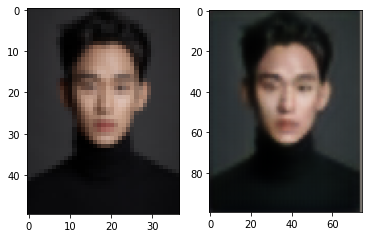

In [59]:
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(result[0])